# Antibiotic Indication Processig - BioClinical_BERT (Subsets)
Check the performance of the model on different training set sizes.
4000 -> 3200 -> 2800 -> etc.

Pre-requisites:

1. Set Runtime --> Change Runtime type --> GPUs (or TPUs)
2. Copy the data file (indications, labeled) into `/content/`
3. Set the model type

Install and load libraries

In [14]:
# --- Check for Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# --- Install packages
if IN_COLAB:
  !pip install -q transformers datasets
  !pip install -q sacremoses


# --- Load libraries
# Standard libraries
import copy
import glob
import os

# DS libs
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pathlib import Path
from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

from transformers import AutoTokenizer, EvalPrediction, pipeline, \
  AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers.pipelines.pt_utils import KeyDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [15]:
# Mounting Google Drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  print("Mounted Google Drive at /content/drive")
else:
  print("Current work directory:", os.getcwd())

Current work directory: /home/kevin/DPhil/Projects/EHR-Indication-Processing/02_Models/02_BERTs/Bio_ClinicalBERT


In [16]:
if torch.cuda.is_available():  
  cuda_device = "cuda:0" 
else:  
  cuda_device = "cpu" 

print(f'Using device: {cuda_device}')

!nvidia-smi

Using device: cuda:0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Oct 23 13:51:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+=================

## Specify Parameters

In [17]:
# --- Model parameters
model_selection = "Bio_ClinicalBERT"

model_dict = {
    "Base BERT": "bert-base-uncased",
    "Bio_ClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
    
}

# --- Paths
# Base data path
base_data_path = Path("../../../00_Data/")
# Data Path (training, testing, etc.)
data_path =  base_data_path / "publication_ready"
# Export Path (model checkpoints, predictions, etc.)
export_path = base_data_path / "export" / "Bio_ClinicalBERT_Iterative"
# Model Path (pre-trained models)
# model_weight_path = export_path / "Weights"

assert base_data_path.is_dir(),\
  f"{base_data_path} either doesn't exist or is not a directory."
export_path.mkdir(exist_ok=True)
# model_weight_path.mkdir(exist_ok=True)


# --- Misc settings
# Model names
model_name_display = model_selection
model_hf_id = model_dict[model_selection]  # Huggingface name/identifier

# Training Set Sizes (max 4000)
training_set_sizes = (500, 1000, 2000, 4000)
# training_set_sizes = tuple(reversed(training_set_sizes))  # Check whether reproducability is set correctly


## Import and check data
Import the training, internal and external test sets & check the splits and data

In [18]:
# Import data --> upload into "Files" on the left-hand panel
train_eval_df = pd.read_csv(
    data_path / 'training_oxford_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

test_oxford_df = pd.read_csv(
    data_path / 'testing_oxford_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

test_banbury_df = pd.read_csv(
    data_path / 'testing_banbury_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

House keeping:
- Create some nice labels and label<->ID mappers

In [19]:
# --- Create some usable labels
labels = [label for label in train_eval_df.keys() if label not in ['Indication']]
labels_pretty = [" ".join(word.capitalize() for word in label.split("_")) for label in labels]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

## Download Pretrained models and tokeniser
Download the pretrained model and tokeniser from HuggingFace

In [20]:
# Tokeniser
tokenizer = AutoTokenizer.from_pretrained(model_hf_id)

# Classification model
def model_init():
     return AutoModelForSequenceClassification.from_pretrained(
          model_hf_id,
          problem_type="multi_label_classification", 
          num_labels=len(labels),
          id2label=id2label,
          label2id=label2id
          )


## Define Data Preprocessing
Using AutoTokenizer.

NB: labels needs to be *floats*, not integers for PyTorch to work.

In [21]:
def prepare_datasets(train_eval_df, test_internal_df, test_external_df, 
                     test_size=0.15, 
                     random_state=42,
                     shuffle=True):
    """Create Huggingface datasets, split training set into training and evaluation set.
    Use sklearn's train_test_split function to split the training set.
    """
    train_df, eval_df = train_test_split(
        train_eval_df, 
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle)

    print("Data set size overview:")
    print(f"- Training set: {train_df.shape[0]}")
    print(f"- Evaluation set: {eval_df.shape[0]}")
    print(f"- Testing Oxford set: {test_oxford_df.shape[0]}")
    print(f"- Testing Banbury set: {test_banbury_df.shape[0]}")
    print()

    # --- Turn into Huggingface datasets
    indication_data = datasets.DatasetDict({
        "train": Dataset.from_pandas(train_df, preserve_index=False),
        "eval": Dataset.from_pandas(eval_df, preserve_index=False),
        "test": Dataset.from_pandas(test_internal_df, preserve_index=False),
        "test_external": Dataset.from_pandas(test_external_df, preserve_index=False),
    })

    return indication_data

In [22]:
def encode_data(data):
  """Encode the indications and add labels to the data.
  """
  text = data["Indication"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: data[k] for k in data.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

## Define the Model
We load a pre-trained model from the Hugginface portal/hub and fintetune it for our task.

Set training arguments (for Hugging face trainer API) 

In [23]:
# --- Training arguments
batch_size = 8
metric_name = "f1"
leanring_rate = 2e-5
num_train_epochs = 5
weight_decay=0.01

Define multi label metrics

In [24]:
# Source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # First, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # Finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, probs, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # Return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

## Define Evaluation & Metrics

### Internal test set


Apply the signmoid function to convert to probabilities & binarise

In [25]:
pred_threshold = 0.5
averaging_method = "weighted"

def calculate_metrics(predictions_raw, true_labels):
    """Calculate metrics for the predictions.
    """
    # --- Preprocess Predictions
    # Binarise the predictions
    sigmoid = torch.nn.Sigmoid()
    predictions_probs = sigmoid(torch.Tensor(predictions_raw))
    predictions_binarised = (predictions_probs > pred_threshold) * 1

    # --- Calculate per class metrics
    scores_per_class = {}
    scores_per_class["F1-Score"] = f1_score(y_true=true_labels, y_pred=predictions_binarised, average=None)
    scores_per_class["ROC AUC"] = roc_auc_score(y_true=true_labels, y_score=predictions_binarised, average=None)

    scores_per_class = pd.DataFrame.from_dict(scores_per_class, orient='index', columns=labels_pretty)

    # --- Calculate overall metrics
    scores_average = {}
    scores_average["F1-Score"] = f1_score(y_true=true_labels, y_pred=predictions_binarised, average=averaging_method)
    scores_average["ROC AUC"] = roc_auc_score(y_true=true_labels, y_score=predictions_probs, average=averaging_method)

    # --- Return the results
    return scores_per_class, scores_average


## Run Training & Evaluation Loop

In [26]:
round_scores_dict = {}

# --- Training loop
for training_set_size in training_set_sizes:
    print(f"Training set size: {training_set_size}")
    
    # --- Prepare data
    # Create a subset of the training data to get the top `training_set_size` rows
    train_eval_subset = train_eval_df.head(training_set_size)

    # Split into train/eval & create Huggingface datasets
    indication_dataset = prepare_datasets(train_eval_subset, test_oxford_df, test_banbury_df)

    # Apply preprocessing & set format to PyTorch
    encoded_dataset = indication_dataset\
        .map(encode_data, batched=True, remove_columns=indication_dataset['train'].column_names)
    
    encoded_dataset.set_format("torch")
    
    # --- Setup trainer & run training
    # Set up training arguments
    num_train_epochs = min((4000 // training_set_size) * 5, np.Inf)
    
    training_args = TrainingArguments(
        model_name_display,
        evaluation_strategy = "epoch",
        save_strategy = "no",
        learning_rate=leanring_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        load_best_model_at_end=False,
        metric_for_best_model=metric_name,
        seed=42,
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["eval"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # --- Evaluate on test sets
    # Oxford test set
    predictions_raw_internal = trainer.predict(encoded_dataset["test"]).predictions
    true_labels_internal = encoded_dataset["test"]["labels"]
    scores_internal = calculate_metrics(predictions_raw_internal, true_labels_internal)

    # Banbury test set
    predictions_raw_external = trainer.predict(encoded_dataset["test_external"]).predictions
    true_labels_external = encoded_dataset["test_external"]["labels"]
    scores_external = calculate_metrics(predictions_raw_external, true_labels_external)

    # --- Print results
    print("Internal Test Set")
    print(scores_internal)

    print("External Test Set")
    print(scores_external)


    # --- Save results
    round_scores_dict[training_set_size] = {
        "Internal": scores_internal,
        "External": scores_external,
    }


Training set size: 400
Data set size overview:
- Training set: 340
- Evaluation set: 60
- Testing Oxford set: 2000
- Testing Banbury set: 2000



Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.358469,0.000000,0.778213,0.000000
2,No log,0.296785,0.309278,0.828332,0.066667
3,No log,0.258960,0.444444,0.870288,0.150000
4,No log,0.230575,0.585366,0.886918,0.300000
5,No log,0.215563,0.645669,0.909550,0.416667
6,No log,0.196264,0.696970,0.919489,0.466667
7,No log,0.182783,0.750000,0.933233,0.566667
8,No log,0.168930,0.791367,0.934781,0.616667
9,No log,0.155018,0.808219,0.962172,0.666667
10,No log,0.149362,0.829932,0.948964,0.683333


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.933333     0.939058   0.928105      0.756757          0.840000   
ROC AUC   0.937500     0.950441   0.943619      0.804348          0.897018   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.178571     0.690476        0.647059            0.955125   
ROC AUC   0.549020     0.763636        0.748954            0.958807   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.948905     0.928144         0.210526  
ROC AUC      0.955475     0.944033         0.558824  , {'F1-Score': 0.9036594189631324, 'ROC AUC': 0.9724819155331631})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.966216     0.967368   0.928571      0.838710          0.888889   
ROC AUC   0.968557     0.970061   0.940147      0.861111          0.900000   

          Ent  Orthopaedic  Other Specific  No Spe

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.327211,0.000000,0.799574,0.000000
2,No log,0.264581,0.444444,0.871094,0.144444
3,No log,0.223330,0.645833,0.906717,0.355556
4,No log,0.193221,0.709360,0.932107,0.455556
5,No log,0.172357,0.742857,0.945235,0.522222
6,No log,0.157845,0.818182,0.935185,0.644444
7,No log,0.149664,0.809091,0.933305,0.633333
8,0.220800,0.140080,0.805430,0.942315,0.633333
9,0.220800,0.130486,0.853333,0.944627,0.688889
10,0.220800,0.126136,0.845815,0.933937,0.688889


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.954545     0.957359   0.927473      0.820513          0.884758   
ROC AUC   0.959103     0.963703   0.940003      0.847826          0.949116   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.729412     0.857143        0.756757            0.955075   
ROC AUC   0.803152     0.881561        0.817136            0.958712   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.963610     0.946746         0.300000  
ROC AUC      0.967084     0.958675         0.588235  , {'F1-Score': 0.9311912220977812, 'ROC AUC': 0.9774493745163595})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.978441     0.973169   0.893805      0.971429          0.940171   
ROC AUC   0.982722     0.974440   0.926106      0.972222          0.945670   

               Ent  Orthopaedic  Other Specific  N

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.293464,0.243386,0.830892,0.025000
2,No log,0.236486,0.613546,0.881573,0.283333
3,No log,0.192517,0.755396,0.921179,0.500000
4,No log,0.164048,0.775510,0.941961,0.566667
5,No log,0.137575,0.845638,0.960337,0.683333
6,0.225300,0.120838,0.860927,0.969825,0.700000
7,0.225300,0.109972,0.875817,0.976366,0.725000
8,0.225300,0.102975,0.885993,0.973162,0.758333
9,0.225300,0.093293,0.880259,0.979280,0.750000
10,0.225300,0.090782,0.914826,0.980535,0.825000


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.957655     0.963064   0.941935      0.850000          0.892989   
ROC AUC   0.959375     0.969051   0.956171      0.869565          0.956749   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.735632     0.888889        0.756757            0.964563   
ROC AUC   0.812699     0.900000        0.817136            0.967430   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.966763     0.956268         0.716981  
ROC AUC      0.970898     0.969895         0.779412  , {'F1-Score': 0.9436299865113692, 'ROC AUC': 0.9842637692529835})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.981697     0.985632   0.913793      0.971429          0.932203   
ROC AUC   0.983312     0.985836   0.947027      0.972222          0.944844   

               Ent  Orthopaedic  Other Specific  N

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.293644,0.355731,0.793856,0.086667
2,No log,0.229128,0.612903,0.872740,0.366667
3,No log,0.188785,0.735043,0.912048,0.560000
4,No log,0.159127,0.779944,0.932772,0.626667
5,0.230300,0.140433,0.797814,0.943739,0.673333
6,0.230300,0.129446,0.829396,0.952758,0.740000
7,0.230300,0.124794,0.832891,0.951161,0.740000
8,0.230300,0.112475,0.842105,0.956033,0.740000
9,0.230300,0.106925,0.854167,0.958248,0.773333
10,0.072200,0.104409,0.859375,0.960391,0.780000


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.947368     0.971583    0.95339      0.820513          0.898876   
ROC AUC   0.950000     0.978102    0.96844      0.847826          0.953735   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.826087     0.932039        0.787097            0.966887   
ROC AUC   0.871779     0.936364        0.845022            0.969733   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.976912     0.962319         0.866667  
ROC AUC      0.978895     0.975642         0.882353  , {'F1-Score': 0.9536403908542369, 'ROC AUC': 0.9852620705057655})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.968174     0.982079   0.947826      0.971429          0.946479   
ROC AUC   0.972886     0.983582   0.961067      0.972222          0.953503   

               Ent  Orthopaedic  Other Specific  N

Map:   0%|          | 0/1275 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.258414,0.531120,0.858814,0.200000
2,No log,0.182615,0.770909,0.935371,0.560000
3,No log,0.139845,0.836555,0.957667,0.671111
4,0.241300,0.117563,0.856643,0.967603,0.711111
5,0.241300,0.105801,0.872414,0.969872,0.724444
6,0.241300,0.094484,0.903553,0.971209,0.795556
7,0.089800,0.090546,0.912752,0.973657,0.817778
8,0.089800,0.087551,0.905724,0.974213,0.800000
9,0.089800,0.085569,0.911223,0.974099,0.822222
10,0.055400,0.084886,0.913043,0.974118,0.826667


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.952077     0.974290   0.946695      0.820513          0.892086   
ROC AUC   0.964538     0.979746   0.962164      0.847826          0.967129   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.831461     0.842105        0.797386            0.968889   
ROC AUC   0.862489     0.863636        0.845545            0.971181   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.974766     0.953488         0.640000  
ROC AUC      0.977413     0.969621         0.735294  , {'F1-Score': 0.9490702183962851, 'ROC AUC': 0.986270152348556})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.975124     0.989278   0.951965      0.971429          0.946779   
ROC AUC   0.980787     0.989699   0.961333      0.972222          0.955930   

               Ent  Orthopaedic  Other Specific  No

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.254063,0.508744,0.861392,0.183333
2,No log,0.170866,0.791612,0.933185,0.600000
3,0.247700,0.132288,0.832487,0.959801,0.653333
4,0.247700,0.113254,0.878229,0.970058,0.743333
5,0.090700,0.102619,0.888889,0.970497,0.796667
6,0.090700,0.095235,0.893976,0.971389,0.793333
7,0.090700,0.089250,0.897619,0.973308,0.810000
8,0.052500,0.086737,0.901542,0.973759,0.823333
9,0.052500,0.084038,0.907583,0.974937,0.836667
10,0.038200,0.084111,0.906509,0.974812,0.836667


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.958730     0.971429   0.957082      0.878049          0.924812   
ROC AUC   0.970788     0.976043   0.965391      0.891304          0.966255   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.932039     0.934579        0.841463            0.977336   
ROC AUC   0.969562     0.954031        0.890215            0.979175   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.982857     0.957020         0.807018  
ROC AUC      0.985550     0.977694         0.838235  , {'F1-Score': 0.9633008665711219, 'ROC AUC': 0.9904368895327555})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.972085     0.991453   0.942731           1.0          0.964187   
ROC AUC   0.982886     0.992145   0.952858           1.0          0.972147   

               Ent  Orthopaedic  Other Specific  N

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.192830,0.747953,0.936118,0.511111
2,0.259300,0.124612,0.850299,0.972075,0.697778
3,0.259300,0.097463,0.904645,0.981281,0.806667
4,0.114300,0.083758,0.923939,0.985314,0.851111
5,0.075500,0.080588,0.927142,0.985797,0.857778


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.961538     0.983827   0.961864      0.878049          0.921348   
ROC AUC   0.968207     0.987045   0.973192      0.891304          0.965988   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.853933     0.923077        0.771242            0.979569   
ROC AUC   0.872549     0.936107        0.833658            0.981288   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.979152      0.96830              0.0  
ROC AUC      0.981350      0.98139              0.5  , {'F1-Score': 0.95272568158869, 'ROC AUC': 0.9927920330468551})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.978441     0.992888   0.947826           1.0          0.955307   
ROC AUC   0.982722     0.993561   0.961067           1.0          0.961611   

               Ent  Orthopaedic  Other Specific  No 

Map:   0%|          | 0/3400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.164557,0.813072,0.939674,0.643333
2,0.259400,0.108509,0.876847,0.977832,0.755000
3,0.118000,0.089523,0.898428,0.982073,0.808333
4,0.075300,0.078014,0.910511,0.984830,0.828333
5,0.056000,0.074875,0.921986,0.985103,0.855000


Internal Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.977636     0.983784   0.955603      0.883721          0.951311   
ROC AUC   0.978125     0.986016   0.970532      0.912791          0.982325   

               Ent  Orthopaedic  Other Specific  No Specific Source  \
F1-Score  0.847826     0.943396        0.853503            0.980737   
ROC AUC   0.881840     0.954288        0.880159            0.982581   

          Prophylaxis  Uncertainty  Not Informative  
F1-Score     0.986477     0.971264         0.583333  
ROC AUC      0.989101     0.984263         0.705882  , {'F1-Score': 0.9662431367944361, 'ROC AUC': 0.9918999175917319})
External Test Set
(           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
F1-Score  0.988543     0.989354   0.947826           1.0          0.969529   
ROC AUC   0.993902     0.991308   0.961067           1.0          0.972697   

               Ent  Orthopaedic  Other Specific  N

## Results

Pickle results

In [27]:
# Pickle the round_scores_dict
import pickle

with open(export_path / "round_scores_dict.pkl", "wb") as f:
    pickle.dump(round_scores_dict, f)

In [29]:
from pprint import pprint
pprint(round_scores_dict[400]["Internal"][1])

{'F1-Score': 0.9036594189631324, 'ROC AUC': 0.9724819155331631}


Plot the performance

In [30]:
# Extract the performance from dict
internal_scores_f1 = {}
internal_score_auc = {}

external_scores_f1 = {}
external_score_auc = {}

for training_set_size in training_set_sizes:
    internal_scores_f1[training_set_size] = round_scores_dict[training_set_size]["Internal"][1]["F1-Score"]
    internal_score_auc[training_set_size] = round_scores_dict[training_set_size]["Internal"][1]["ROC AUC"]

    external_scores_f1[training_set_size] = round_scores_dict[training_set_size]["External"][1]["F1-Score"]
    external_score_auc[training_set_size] = round_scores_dict[training_set_size]["External"][1]["ROC AUC"]

# Create one DataFrame
metrics_df = pd.DataFrame.from_dict({
    "Internal Test F1-Score": internal_scores_f1,
    "Internal Test ROC AUC": internal_score_auc,
    "External Test F1-Score": external_scores_f1,
    "External Test ROC AUC": external_score_auc,
})

metrics_df.index.name = "Training Set Size"

metrics_df.to_csv(export_path / "internal_external_f1_auc.csv", index=False)

# Split into internal/external
metrics_internal_df = pd.DataFrame.from_dict({
    "Internal Test F1-Score": internal_scores_f1,
    "Internal Test ROC AUC": internal_score_auc,
})
metrics_internal_df.index.name = "Training Set Size"

metrics_external_df = pd.DataFrame.from_dict({
    "External Test F1-Score": external_scores_f1,
    "External Test ROC AUC": external_score_auc,
})
metrics_external_df.index.name = "Training Set Size"

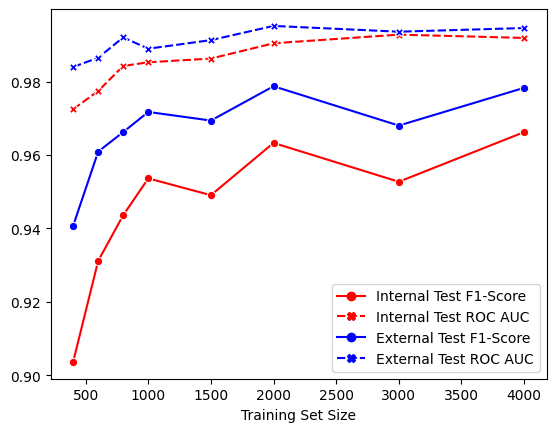

In [32]:
fig, ax = plt.subplots()

sns.lineplot(data=metrics_internal_df, markers=True, palette=['red', 'red'], ax=ax)
sns.lineplot(data=metrics_external_df, markers=True, palette=['blue', 'blue'], ax=ax)

plt.savefig(export_path / "internal_external_f1_auc.png", dpi=300, bbox_inches='tight')